In [1]:
import matplotlib.pyplot as plt
import tools.dataTools as dt
from constants import Constants
import figure_params
import os
import matplotlib.pyplot as plt
import pyaldata as pyal
import pickle
from tqdm.auto import tqdm
from textwrap import wrap
import numpy as np
import pandas as pd

figure_params.set_rc_params
figure_params.setup_directories()

SUBFIG_DIR = Constants.FIG_FOLDER + 'figS3_synthetic/'
if not os.path.exists(SUBFIG_DIR):
    os.makedirs(SUBFIG_DIR)

#run simulations for figure, will take a while to run
import subprocess
os.chdir(Constants.PROJ_DIR)
subprocess.run(["bash", "simulation/fig_simulations/Sfig_synthetic_sims.sh"]) #uncomment code to make datasets if not made yet

<module 'tools.dataTools' from '/home/jcc319/structure_proj/tools/dataTools.py'>

In [2]:
seeds = Constants.SEEDS
repertoires  = Constants.UNIS
reps = repertoires
dataset = '_synth_rad'
sim_set = 'uni_synth_rad'
seed_ex = Constants.SEED_EX

# seeds =   [20,1000003,6885953,1000004,1000000,1000005,1000001,1000006,1000002,1000007]


#### Target and model output

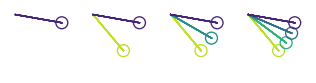

In [3]:
fig, axs = plt.subplots(ncols = len(reps))
for i, rep in enumerate(reps):
    ax = dt.graph_repertoire(dataset, rep, ax = axs[i], graph_all=False)
plt.savefig(SUBFIG_DIR + '/target.pdf', format = 'pdf')

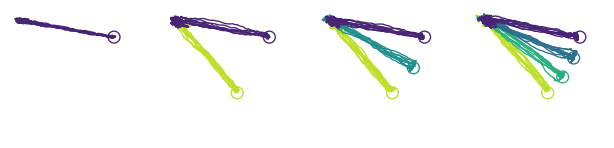

In [4]:
dt.graph_outputs_all(seed_ex, 'uni_synth_rad', reps)
plt.savefig(SUBFIG_DIR + '/output.pdf', format = 'pdf')

#### Calculate comparison measures

In [5]:
datafile = 'uni_10.0_synth_rad'
redo = True
fname = Constants.PROCESSED_DATA_FOLDER + sim_set + '/'+ 'repertoire_comparison_measures_norm.pickle'
# fname = '/home/jcc319/structure_proj/figures_fig/processed/uni_synth_rad/repertoire_comparison_measures.pickle'
if os.path.isfile(fname) & (not redo):
    with open(fname, 'rb') as f:
        measures_df = pickle.load(f)
else:
    #calculate variance for unit activity, latent activity, position, and angle
    rows_list = []
    for seed in tqdm(seeds):
        for repertoire in repertoires:
            #get simulation data
            exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.exec_epoch, 
                subtract_mean=False, datafile = datafile)
            exec_df = dt.perform_pca(exec_df, Constants.PCA_DIMS)
            prep_exec_df = dt.get_pyaldata(sim_set, seed, repertoire, epoch_fun = Constants.prep_exec_epoch, 
                subtract_mean=False, datafile = datafile)
            prep_exec_df = dt.perform_pca(prep_exec_df, Constants.PCA_DIMS)

            #calculate distances between timesteps (for normalization)
            av_df = pyal.trial_average(prep_exec_df, 'target_param')
            dist_tsteps = np.linalg.norm(np.diff(av_df.both_pca.values.tolist(), axis = 1),axis = 2)
            #calculate variance
            var_rates = np.var(prep_exec_df.MCx_rates.values, axis = 0).flatten()
            var_pca = np.var(prep_exec_df.both_pca.values/np.median(dist_tsteps), axis = 0).flatten()
            var_pos = np.var(exec_df.pos.values, axis = 0).flatten()

            temp = {
                'seed': seed,
                'repertoire': repertoire,
                'var_rates': var_rates,
                'var_pca': var_pca,
                'var_pos': var_pos,
            }
            rows_list.append(temp)

    measures_df = pd.DataFrame(rows_list)
    with open(fname, 'wb') as f:
        pickle.dump(measures_df, f)

  0%|          | 0/10 [00:00<?, ?it/s]

#### 3A-C: Variance in activity + output

0.0009765625
0.0009765625
0.9970703125


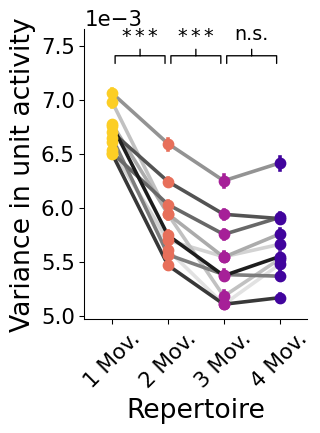

In [6]:
# variance in unit activity
g = dt.compare_measure(measures_df, 'var_rates', reps, stats_alternative = 'greater')
g.set_ylabel("\n".join(wrap('Variance in unit activity')))

plt.savefig(SUBFIG_DIR+ '/var_rates_all.pdf', format = 'pdf', bbox_inches = 'tight')


0.0185546875
0.080078125
0.9814453125


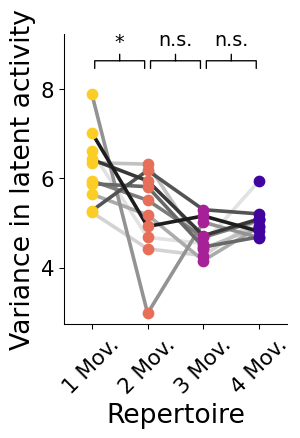

In [7]:
# variance in latent activity
g = dt.compare_measure(measures_df, 'var_pca', reps, stats_alternative = 'greater', ci=None, estimator=np.median)
g.set_ylabel("\n".join(wrap('Variance in latent activity')))
plt.savefig(SUBFIG_DIR+ '/var_pca_all.pdf', format = 'pdf', bbox_inches = 'tight')


0.0009765625
0.0419921875
0.0009765625


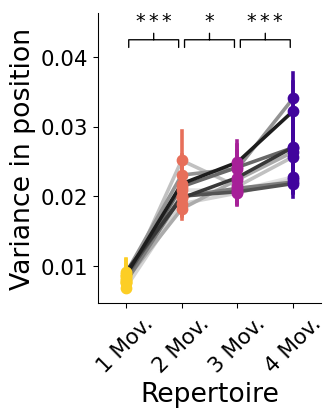

In [8]:
# variance in position
g = dt.compare_measure(measures_df, 'var_pos', reps, stats_alternative = 'less')
g.set_ylabel("\n".join(wrap('Variance in position')))

plt.savefig(SUBFIG_DIR+ '/var_position_all.pdf', format = 'pdf', bbox_inches = 'tight')
